In [1]:
import torch
import numpy as np
# 检查是否可以利用GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')

CUDA is not available.


In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# number of subprocesses to use for data loading
num_workers = 0
#每批加载16张图片
batch_size = 16
# percentage of training set to use as validation
valid_size = 0.2

In [4]:
# 将数据转换为torch.FloatTensor，并标准化。
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [5]:
# 选择训练集与测试集的数据
train_data = datasets.CIFAR10('data', train=True,
                             download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [7]:
# define samplers for obtaining training and validation batches
#pytorch随机采样的方法 SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [8]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [9]:
# 图像分类中10类别
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

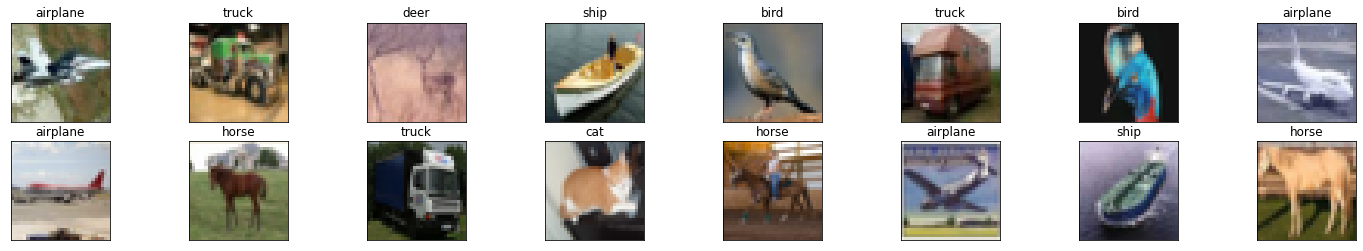

In [10]:
#查看训练集中的一批样本
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
     img = img / 2 + 0.5  # unnormalize
     plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# 获取一批样本
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# 显示图像，标题为类名
fig = plt.figure(figsize=(25, 4))
# 显示16张图片
for idx in np.arange(16):
   ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
   imshow(images[idx])
   ax.set_title(classes[labels[idx]])

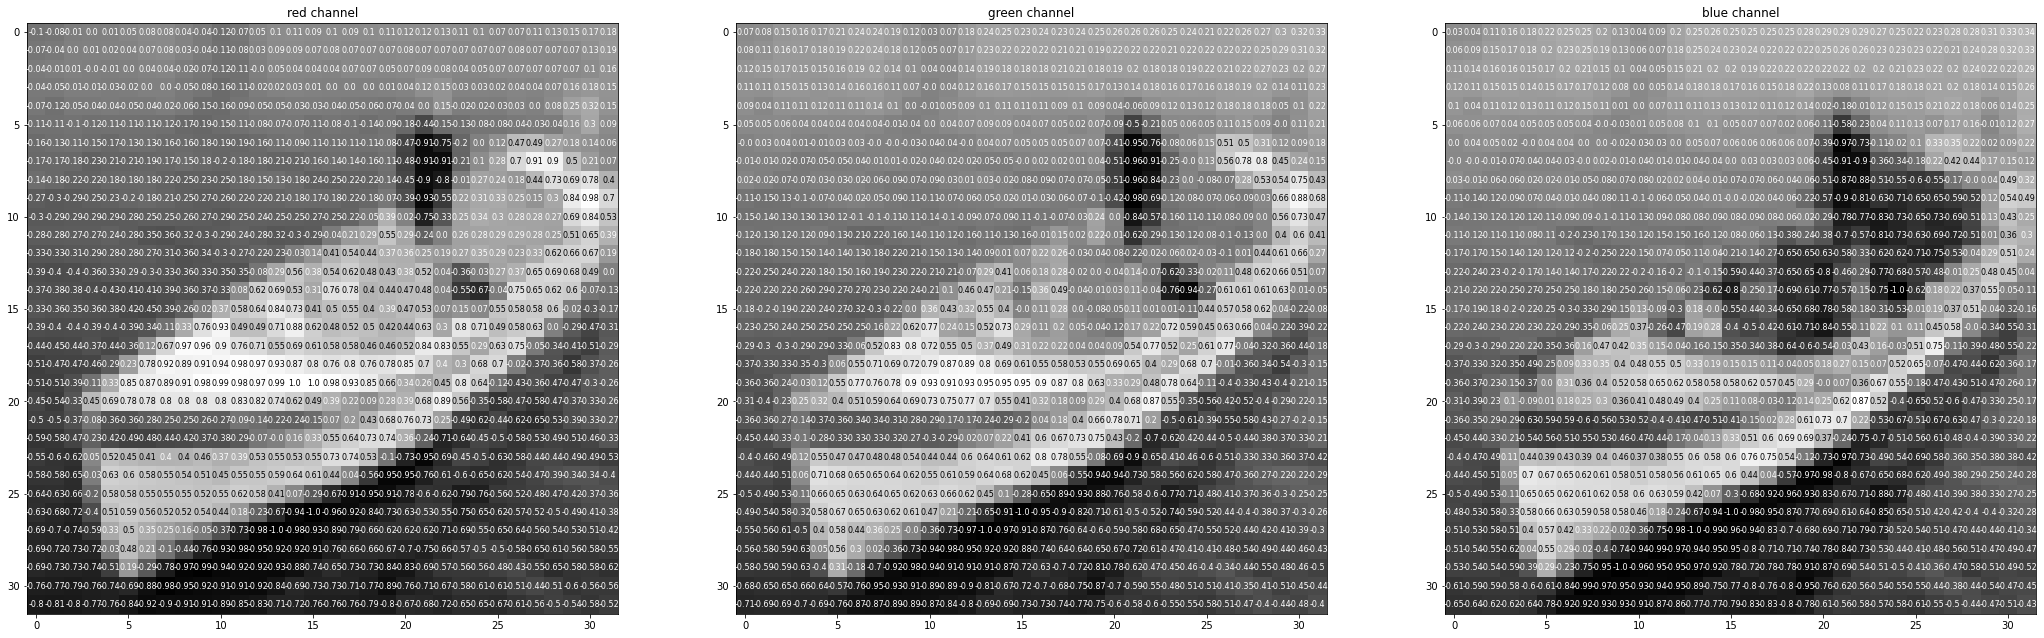

In [11]:
#查看一张图像中的更多细节
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']
fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):#3
   ax = fig.add_subplot(1, 3, idx + 1)
   img = rgb_img[idx]
   ax.imshow(img, cmap='gray')
   ax.set_title(channels[idx])
   width, height = img.shape
   thresh = img.max()/2.5
   for x in range(width):
      for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                   horizontalalignment='center',
                   verticalalignment='center', size=8,
                   color='white' if img[x][y]<thresh else 'black')

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# 定义卷积神经网络结构
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷积层 (32x32x3的图像)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # 卷积层(16x16x16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # 卷积层(8x8x32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # 最大池化层
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout层 (p=0.3)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# 使用GPU
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [14]:
import torch.optim as optim
# 使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()
# 使用随机梯度下降，学习率lr=0.01
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [24]:
#训练卷积神经网络模型
# 训练模型的次数
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

   # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # 训练集的模型 #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)# #计算所有batch的损失和

    ######################    
    # 验证集的模型#
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

    # 计算平均损失
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    # 显示训练集与验证集的损失函数 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # 如果验证集损失函数减少，就保存模型。
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.014008 	Validation Loss: 1.690479
Validation loss decreased (inf --> 1.690479).  Saving model ...
Epoch: 2 	Training Loss: 1.577152 	Validation Loss: 1.458225
Validation loss decreased (1.690479 --> 1.458225).  Saving model ...
Epoch: 3 	Training Loss: 1.411743 	Validation Loss: 1.316989
Validation loss decreased (1.458225 --> 1.316989).  Saving model ...
Epoch: 4 	Training Loss: 1.296603 	Validation Loss: 1.231147
Validation loss decreased (1.316989 --> 1.231147).  Saving model ...
Epoch: 5 	Training Loss: 1.194605 	Validation Loss: 1.096895
Validation loss decreased (1.231147 --> 1.096895).  Saving model ...
Epoch: 6 	Training Loss: 1.113374 	Validation Loss: 1.074702
Validation loss decreased (1.096895 --> 1.074702).  Saving model ...
Epoch: 7 	Training Loss: 1.041332 	Validation Loss: 0.979842
Validation loss decreased (1.074702 --> 0.979842).  Saving model ...
Epoch: 8 	Training Loss: 0.985121 	Validation Loss: 0.952663
Validation loss decreased (0.97984

In [15]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [16]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    #1是每行的最大值
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()#true  falese可以直接加减
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.704417

Test Accuracy of airplane: 83% (832/1000)
Test Accuracy of automobile: 88% (884/1000)
Test Accuracy of  bird: 58% (589/1000)
Test Accuracy of   cat: 52% (527/1000)
Test Accuracy of  deer: 76% (769/1000)
Test Accuracy of   dog: 67% (673/1000)
Test Accuracy of  frog: 87% (871/1000)
Test Accuracy of horse: 79% (797/1000)
Test Accuracy of  ship: 85% (855/1000)
Test Accuracy of truck: 83% (839/1000)

Test Accuracy (Overall): 76% (7636/10000)


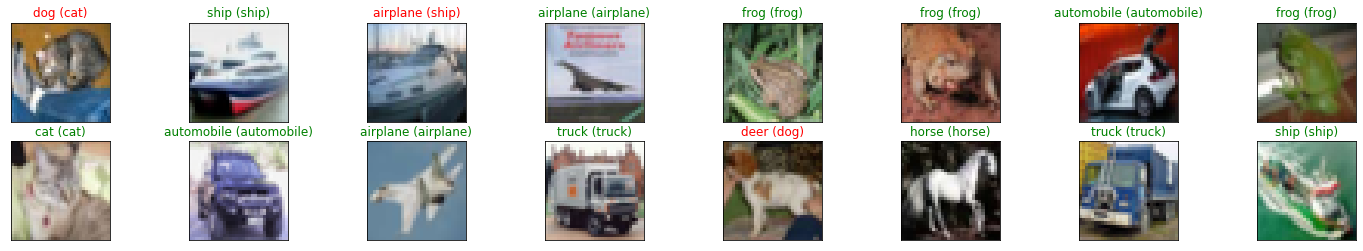

In [37]:
 # obtain one batch of test images
 dataiter = iter(test_loader)#
 images, labels = dataiter.next()
 images.numpy()
 
 # move model inputs to cuda, if GPU available
 if train_on_gpu:
     images = images.cuda()
 
# get sample outputs
output = model(images)
# convert output probabilities to predicted class，1是每行的最大值
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))